***<h1> КТ 2. Разведочный анализ данных на датасете "Walmart"  </h1>***

#### Работу выполнила Фадеева А.В. Э-2208

Мой github: https://github.com/piece-of-infinity/machine-learning-unecon

## <a class="anchor" id="1"> Навигация:

[Описание данных](#2)<br>
[1. Предобработка данных](#3)<br>
[2. Визуализация данных.  Анализ на распределение, связь и зависимость](#4)<br>
[3. Моделирование](#5)<br>
[4. Random Forest](#6)<br>
[Выводы](#7)<br>

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [105]:
#загружаем наши данные
df = pd.read_csv('Walmart.csv')

In [106]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [108]:
df.shape

(6435, 8)

<b><a class="anchor" id="2"></a><div class="alert alert-light">Описание данных</b>

Данные включают следующие функции, каждая из которых оказывает определенное влияние на Weekly_Sales:

1. Weekly_Sales (целевая переменная): еженедельный доход каждого магазина.

2. Holiday_Flag (бинарная функция): указывает, включает ли неделя праздник (1, если это праздничная неделя, 0 в противном случае).

3. Temperature (числовая функция): средняя температура за неделю.

4. Fuel_Price (числовая функция): еженедельная цена на топливо.

5. CPI (индекс потребительских цен) (числовая функция): измеряет среднее изменение цен, уплачиваемых потребителями с течением времени, что отражает инфляцию.

6. Unemployment (числовая функция): еженедельный уровень безработицы.

7. Date (функция даты): дата каждого наблюдения.

[Вернуться к Навигации](#1)

<b><a class="anchor" id="3"></a><div class="alert alert-light">1. Предобработка данных</b>

In [109]:
df.columns = df.columns.str.lower()

In [110]:
# конверитируем дату в формат datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

In [111]:
# проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   store         6435 non-null   int64         
 1   date          6435 non-null   datetime64[ns]
 2   weekly_sales  6435 non-null   float64       
 3   holiday_flag  6435 non-null   int64         
 4   temperature   6435 non-null   float64       
 5   fuel_price    6435 non-null   float64       
 6   cpi           6435 non-null   float64       
 7   unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [112]:
# есть ли пропущенные значения
df.isnull().sum()

store           0
date            0
weekly_sales    0
holiday_flag    0
temperature     0
fuel_price      0
cpi             0
unemployment    0
dtype: int64

Пропущенных значений нет.

In [113]:
# проверка на дубликаты
df.duplicated().sum()

0

Дубликатов тоже нет.

С данными все супер, идем дальше.

[Вернуться к Навигации](#1)

<b><a class="anchor" id="4"></a><div class="alert alert-light">2. Визуализация данных.  Анализ на распределение, связь и зависимость</b>

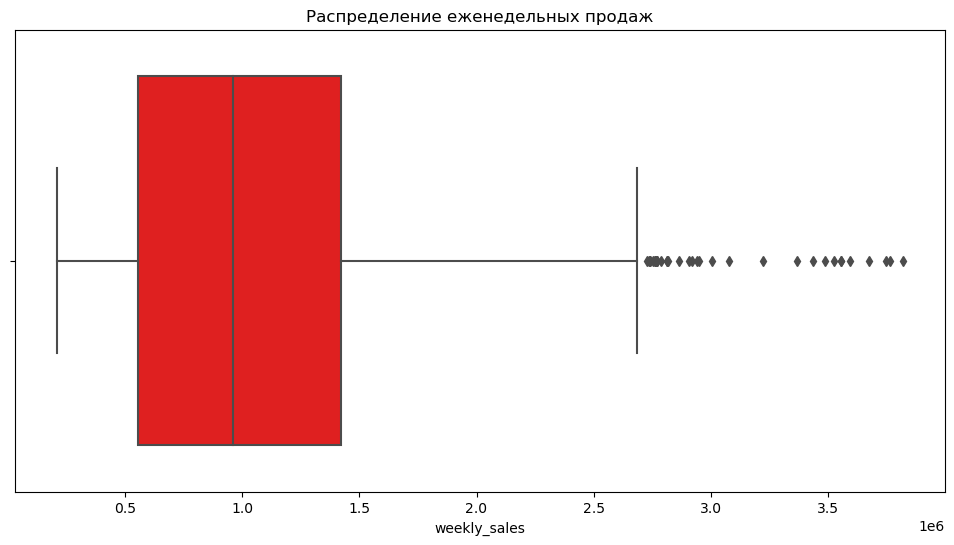

In [114]:
# анализ выбросов
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['weekly_sales'], color='red')
plt.title('Распределение еженедельных продаж')
plt.show()

Есть выбросы, давайте их удалим.

In [115]:
# удаление выбросов (верхние 1% цен)
price_threshold = df['weekly_sales'].quantile(0.99)
df = df[df['weekly_sales'] <= price_threshold]

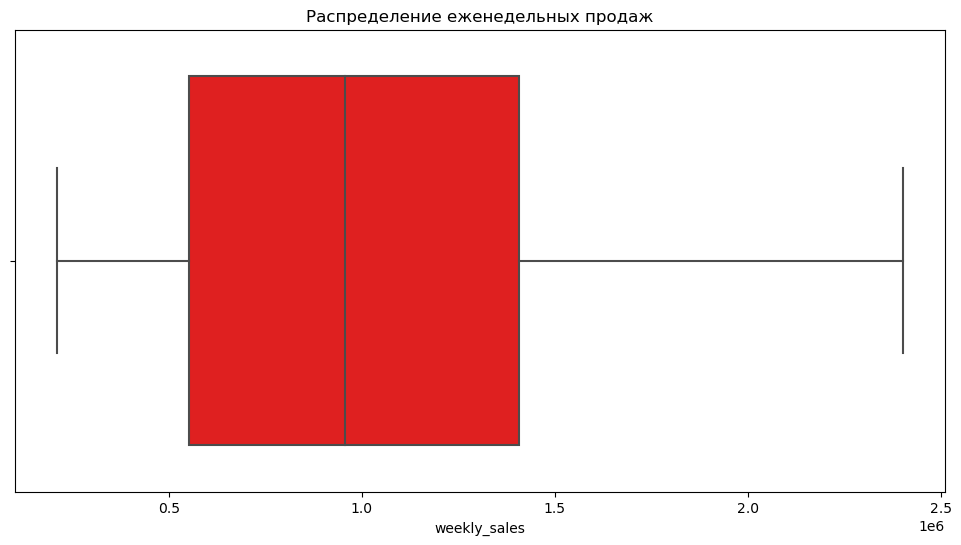

In [116]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['weekly_sales'], color='red')
plt.title('Распределение еженедельных продаж')
plt.show()

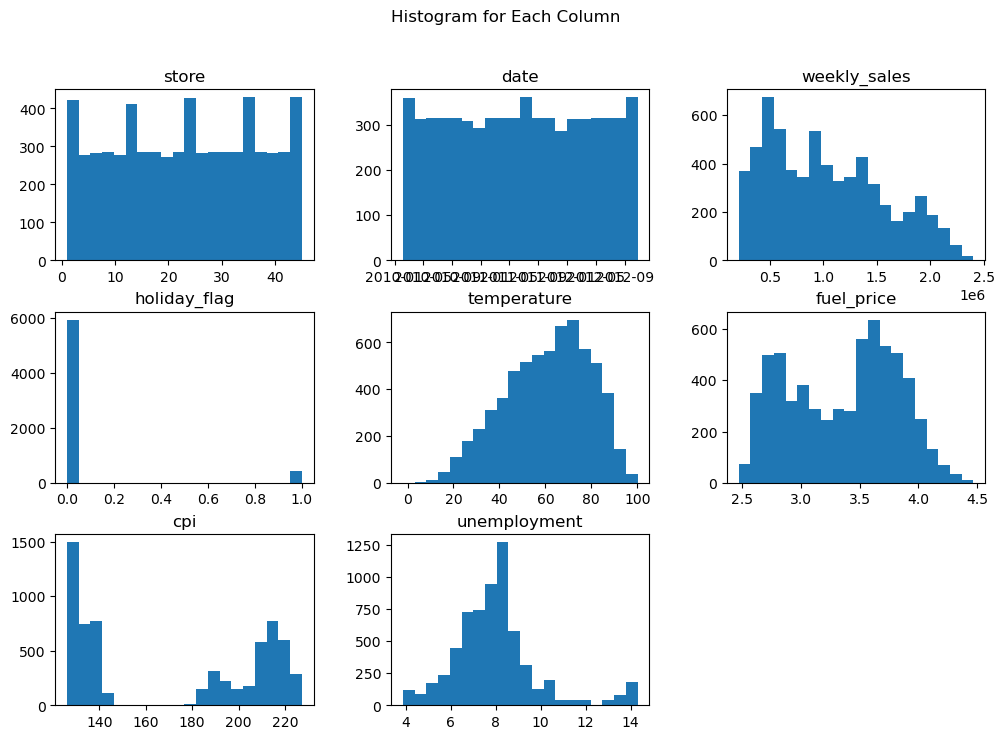

In [117]:
df.hist(figsize=(12, 8), bins=20, grid=False)
plt.suptitle("Histogram for Each Column")
plt.show()

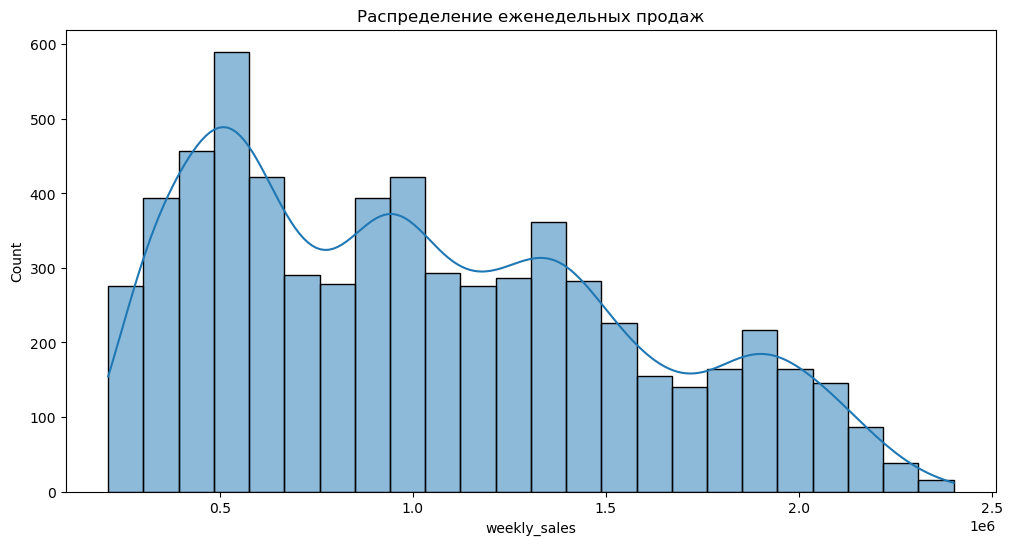

In [118]:
# визуализация распределения целевой переменной
plt.figure(figsize=(12, 6))
sns.histplot(df['weekly_sales'], kde=True)
plt.title('Распределение еженедельных продаж')
plt.show()

Выводы по выбросам и распределению:
1. Распределение является асимметричным: хвост справа длиннее, чем слева, то есть встречаются как низкие, так и очень высокие значения продаж, но высокие значения встречаются реже.

2. Большинство значений продаж сосредоточено в диапазоне от примерно 300 000 до 1 500 000. Это видно по высоким столбцам в этой области.

3. Можно заметить несколько локальных максимумов (мод), что говорит о возможной мульти-модальности распределения. Это может указывать на наличие разных групп или сегментов с отличающимися уровнями продаж.

4. Наиболее частые значения продаж (пик гистограммы) находятся в районе 500 000–600 000.

5. В целом, большинство недельных продаж сосредоточено в среднем и ниже среднего диапазоне, но есть и периоды с очень высокими продажами, что может быть связано с сезонностью, акциями или другими факторами.

6. Видимых резких скачков или аномалий на графике нет, что говорит о том, что основные выбросы уже были удалены.

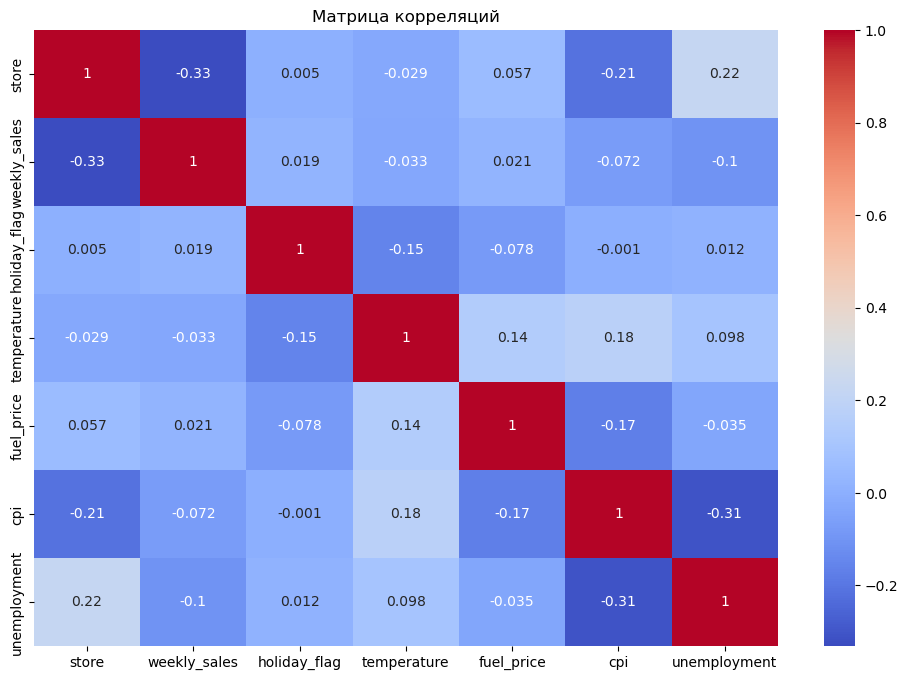

In [119]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

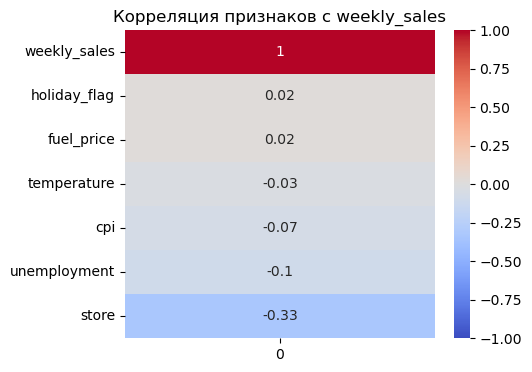

In [120]:
# корреляция по weekly_sales
corr_with_sales = pd.Series({
    'store': -0.33,
    'holiday_flag': 0.02,
    'temperature': -0.03,
    'fuel_price': 0.02,
    'cpi': -0.07,
    'unemployment': -0.10,
    'weekly_sales': 1.00
}).sort_values(ascending=False)

plt.figure(figsize=(5, 4))
sns.heatmap(corr_with_sales.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title('Корреляция признаков с weekly_sales')
plt.show()


#### Краткие выводы
- store: Умеренная отрицательная корреляция (-0.33) - возможно, номера магазинов связаны с их размерами или локацией, что влияет на продажи.

- unemployment: Слабая отрицательная корреляция (-0.10) - при росте безработицы продажи немного снижаются.

- cpi: Очень слабая отрицательная корреляция (-0.07) - инфляция почти не влияет на продажи.

- temperature, fuel_price, holiday_flag: Корреляция практически отсутствует (значения близки к нулю), то есть эти признаки напрямую почти не связаны с недельными продажами.

#### Вывод:
Среди всех признаков только переменная store показывает заметную (отрицательную) связь с недельными продажами. Остальные признаки либо слабо, либо практически не связаны с weekly_sales. Это может означать, что для объяснения или прогнозирования weekly_sales нужны дополнительные признаки или нелинейные методы анализа.

[Вернуться к Навигации](#1)

<b><a class="anchor" id="5"></a><div class="alert alert-light">3. Моделирование</b>

In [121]:
# подготовка данных для моделирования
X = df.drop(['weekly_sales', 'date'], axis=1)
y = df['weekly_sales']

In [122]:
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Берем 80/20 как в классическом (универсальном) случае

In [123]:
# масштабирование
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [124]:
# обучение моделей
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Support Vector Regression': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[name] = {'rmse': rmse, 'r2': r2}

1. Linear Regression (Линейная регрессия): Простейшая модель, которая предполагает линейную зависимость между признаками и целевой переменной. Она находит прямую линию (в многомерном случае — гиперплоскость), которая наилучшим образом приближает данные. Проста в реализации, но может быть неэффективна, если зависимость нелинейная.

2. Ridge Regression (Регрессия с гребневой регуляризацией): Это модификация линейной регрессии, которая использует L2-регуляризацию. Регуляризация помогает предотвратить переобучение модели, уменьшая значения весов модели. Полезно, когда в данных присутствует мультиколлинеарность (сильная корреляция между признаками).

3. Lasso Regression (Регрессия с LASSO-регуляризацией): Ещё одна модификация линейной регрессии, но использующая L1-регуляризацию. L1-регуляризация может приводить к тому, что некоторые веса модели становятся равными нулю, что эффективно выполняет отбор признаков.

4. Elastic Net (Эластичная сеть): Комбинирует L1 и L2 регуляризацию из Ridge и Lasso. Позволяет контролировать степень влияния каждой регуляризации и часто дает хорошие результаты.

5. Decision Tree Regressor (Регрессия на основе дерева решений): Создает дерево решений для прогнозирования значений. Проста для интерпретации, но может быть склонна к переобучению, особенно на сложных данных.

6. Random Forest Regressor (Регрессия случайного леса): Ансамблевая модель, которая объединяет множество деревьев решений. Более устойчива к переобучению, чем одиночное дерево решений, и обычно дает более точные прогнозы.

7. Gradient Boosting Regressor (Регрессия с градиентным бустингом): Ансамблевая модель, которая последовательно строит деревья решений, минимизируя ошибку предыдущих деревьев. Обычно дает очень хорошие результаты, но может быть вычислительно затратной.

8. AdaBoost Regressor (Регрессия с AdaBoost): Ещё одна ансамблевая модель, которая использует бустинг для объединения слабых моделей (часто деревьев решений). Проще в реализации и быстрее, чем Gradient Boosting, но обычно дает менее точные результаты.

9. Support Vector Regression (SVR - Регрессия опорных векторов): Ищет оптимальную гиперплоскость (в многомерном пространстве) для разделения данных. Может быть эффективна для нелинейных зависимостей, особенно если использовать ядро (kernel).

10. K-Nearest Neighbors Regressor (K-ближайших соседей): Прогнозирует значение на основе k ближайших точек в пространстве признаков. Проста в реализации, но может быть неэффективна для больших наборов данных.


Все эти модели являются регрессионными моделями, то есть они предназначены для предсказания непрерывной целевой переменной (в данном случае — цены на недвижимость). Выбор наилучшей модели зависит от конкретных особенностей данных и требований к задаче.

In [125]:
# вывод результатов
print("Model Performance:")
for name, metrics in results.items():
    print(f"{name}: RMSE = {metrics['rmse']:.2f}, R-squared = {metrics['r2']:.2f}")

Model Performance:
Linear Regression: RMSE = 497333.15, R-squared = 0.17
Ridge Regression: RMSE = 497335.41, R-squared = 0.17
Lasso Regression: RMSE = 497333.14, R-squared = 0.17
Elastic Net: RMSE = 506404.08, R-squared = 0.14
Decision Tree: RMSE = 140019.09, R-squared = 0.93
Random Forest: RMSE = 107966.58, R-squared = 0.96
Gradient Boosting: RMSE = 156176.97, R-squared = 0.92
AdaBoost: RMSE = 391406.59, R-squared = 0.49
Support Vector Regression: RMSE = 552441.69, R-squared = -0.02
K-Nearest Neighbors: RMSE = 301477.53, R-squared = 0.70



 Лучшая модель: Random Forest (RMSE: 107966.58, R-squared: 0.96)


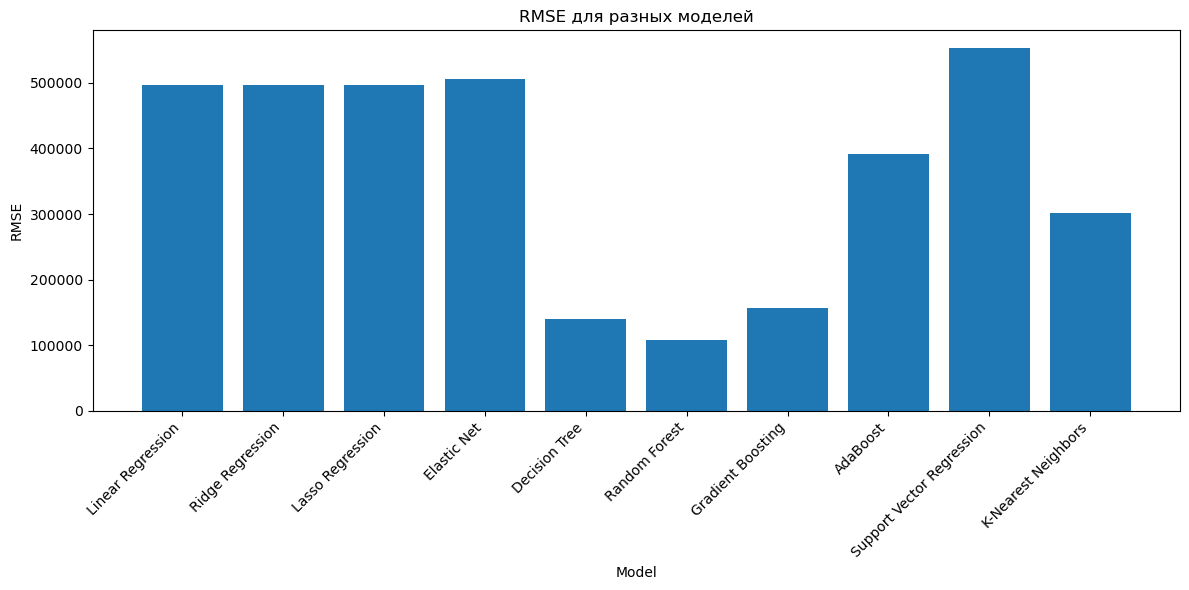

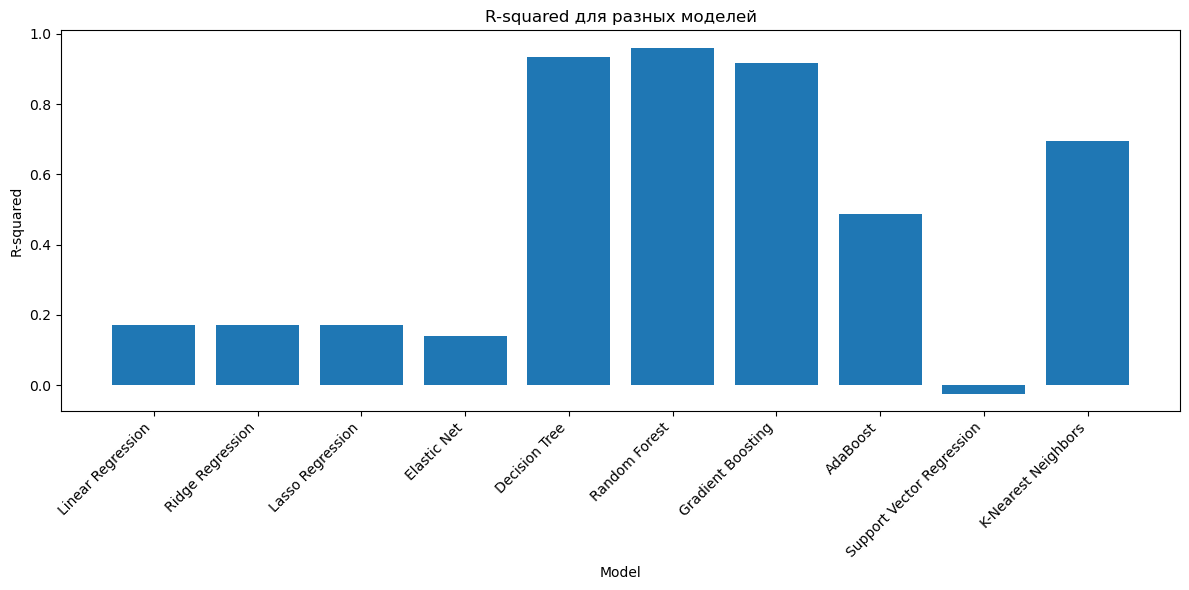

In [126]:
# выбор лучшей модели (на основе RMSE)
best_model_name = min(results, key=lambda k: results[k]['rmse'])
best_rmse = results[best_model_name]['rmse']
best_r2 = results[best_model_name]['r2']
print(f"\n Лучшая модель: {best_model_name} (RMSE: {best_rmse:.2f}, R-squared: {best_r2:.2f})")

# визуализация результатов
rmse_values = [metrics['rmse'] for metrics in results.values()]
r2_values = [metrics['r2'] for metrics in results.values()]
model_names = list(results.keys())

plt.figure(figsize=(12, 6))
plt.bar(model_names, rmse_values)
plt.title('RMSE для разных моделей')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(model_names, r2_values)
plt.title('R-squared для разных моделей')
plt.xlabel('Model')
plt.ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Выводы:

 В результате анализа данных о недельных продажах магазинов с использованием различных моделей регрессии наилучшие результаты показала модель Random Forest. Для этой модели значение RMSE (Root Mean Squared Error) составило 107,966.58, а коэффициент детерминации R-squared - 0.96.

Значение RMSE в 107,966.58 указывает на среднюю ошибку прогноза недельных продаж примерно в 108 тысяч долларов. Это значение следует рассматривать в контексте диапазона продаж магазинов, где недельные продажи могут превышать миллион долларов, что делает ошибку прогноза относительно небольшой.

Коэффициент R-squared, равный 0.96, свидетельствует о том, что модель объясняет 96% вариации в недельных продажах магазинов. Это говорит о высокой точности модели и её способности учитывать основные факторы, влияющие на объём продаж, такие как температура, цена топлива, индекс потребительских цен и уровень безработицы.

Модель Random Forest выбрана как лучшая, поскольку она показала наименьшее значение RMSE и наибольший R-squared среди всех протестированных моделей. Это указывает на то, что именно эта модель обеспечивает наиболее точные и надёжные прогнозы недельных продаж магазинов на данном наборе данных.


[Вернуться к Навигации](#1)

<b><a class="anchor" id="6"></a><div class="alert alert-light">4. Random Forest</b>

In [127]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [128]:
# предсказания
y_pred = model.predict(X_test)

Обоснование выбора метрик
1. MSE - измеряет среднее значение квадратов разностей между фактическими и предсказанными значениями модели
2. RMSE (Root Mean Squared Error) - основная метрика, так как:
<br>учитывает большие ошибки (штрафует за большие отклонения),bмеет ту же размерность, что и целевая переменная, что делает интерпретацию проще?чувствительна к выбросам, что важно при прогнозировании цен
3. MAE (Mean Absolute Error) - дополнительная метрика:
легче интерпретируется (средняя абсолютная ошибка в рупиях), менее чувствительна к выбросам, чем RMSE
4. R² (Коэффициент детерминации):
показывает долю дисперсии, объясненную моделью, удобен для сравнения моделей

In [129]:
# оценка модели
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nОценка модели Random Forest:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")


Оценка модели Random Forest:
MSE: 11656782935.00
RMSE: 107966.58
MAE: 64725.11
R2: 0.96


In [130]:
# кросс-валидация (5 фолдов, scoring='neg_mean_squared_error')
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# переводим в RMSE
rmse_scores = np.sqrt(-cv_scores)
print(f"\nКросс-валидация RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")


Кросс-валидация RMSE: 641120.14 ± 152186.09


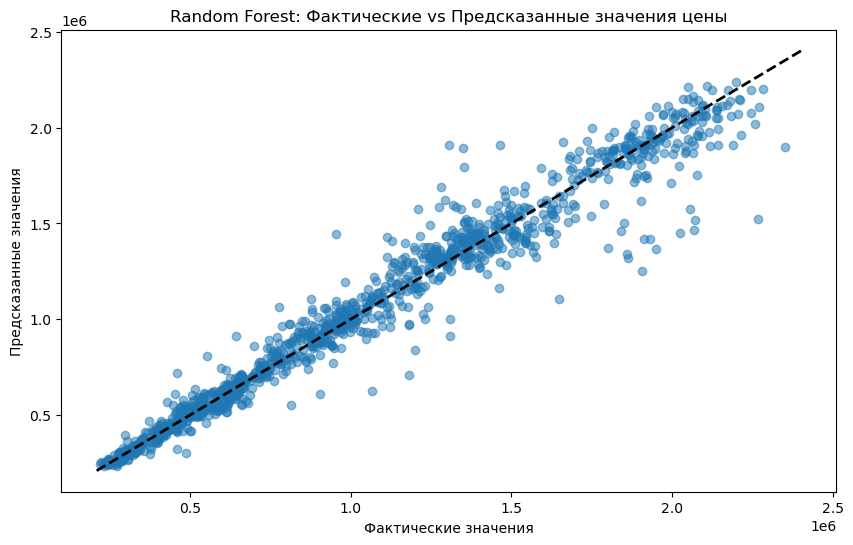

In [131]:
#визуализация предсказаний
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Random Forest: Фактические vs Предсказанные значения цены')
plt.show()

Модель Random Forest в целом хорошо прогнозирует недельные продажи магазинов Walmart - предсказанные значения близки к фактическим. Большинство точек располагается вдоль диагонали, что свидетельствует о высокой точности модели.

- Разброс точек увеличивается с ростом объёма продаж:

<br> Для магазинов с очень высокими недельными продажами отклонения между реальными и предсказанными значениями становятся больше. Это типичная ситуация для регрессионных задач с длинным "хвостом" распределения: чем больше значение целевой переменной, тем выше абсолютная ошибка. </br>

- Небольшое количество точек далеко от диагонали:

<br>Такие случаи говорят о том, что для отдельных недель или магазинов модель ошиблась сильнее обычного. Это могут быть периоды с необычно высокими или низкими продажами (например, праздничные недели, распродажи или другие аномалии, которые сложно учесть на основе имеющихся признаков).</br>

- Чёрная пунктирная линия - идеальное совпадение (y = x):

<br> Чем ближе точки к этой линии, тем точнее прогноз модели. Большая часть точек располагается вблизи этой линии, что подтверждает высокую точность модели Random Forest на ваших данных. </br>

##### Вывод:
Random Forest обеспечивает точные прогнозы для основной массы магазинов и недель. Однако для недель с экстремально высокими продажами точность несколько ниже - это связано с особенностями распределения данных и ограничениями признаков. Для дальнейшего повышения точности в "хвостах" можно рассмотреть добавление новых признаков (например, информации о промоакциях, локальных событиях, погоде) или применение специализированных методов для работы с выбросами.

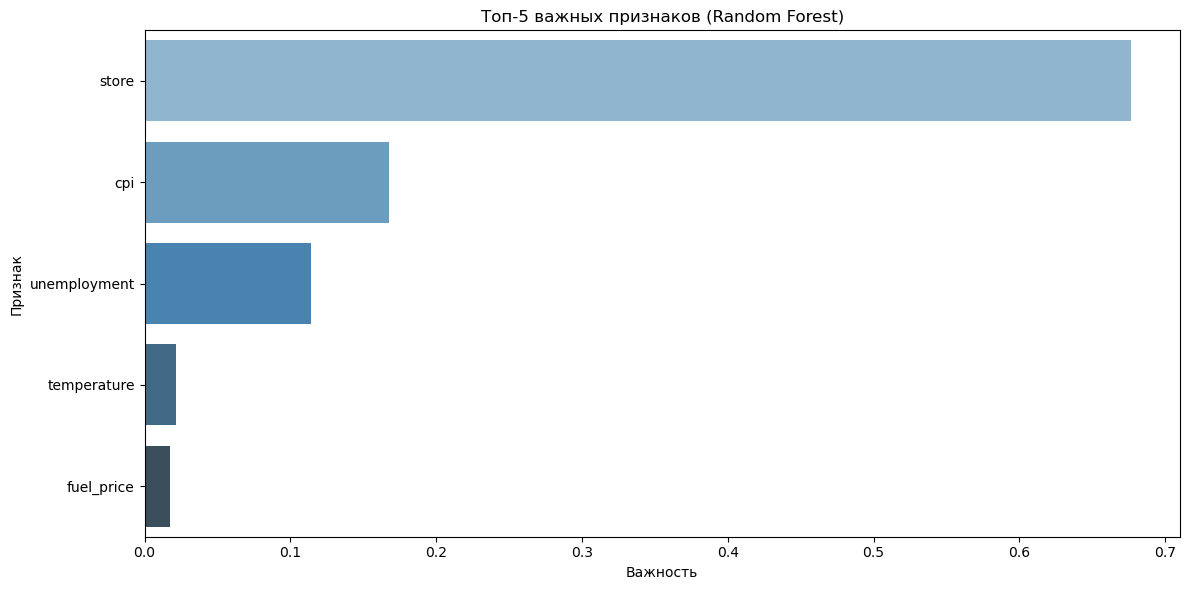


Модель сохранена как 'random_forest_walmart.pkl'


In [132]:
# Анализ важности признаков
importances = model.feature_importances_
feature_names = X.columns

# DataFrame с важностями
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importances_df = importances_df.sort_values('Importance', ascending=False)

# Визуализация топ-5 признаков
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(5), palette='Blues_d')
plt.title('Топ-5 важных признаков (Random Forest)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

# Сохранение модели
import joblib
joblib.dump(model, 'random_forest_walmart.pkl')
print("\nМодель сохранена как 'random_forest_walmart.pkl'")

1. Все признаки в топе - это основные характеристики магазина и макроэкономические показатели
В топ-5 вошли такие признаки, как номер магазина (Store), уровень безработицы (Unemployment), индекс потребительских цен (CPI), температура (Temperature) и цена топлива (Fuel_Price). Это ключевые факторы, которые наиболее существенно влияют на недельные продажи.

2. Наибольший вклад в прогноз вносят характеристики магазина и экономические показатели
Признак Store отражает индивидуальные особенности каждого магазина (размер, локация, клиентская база и пр.), что напрямую влияет на объем продаж. Экономические индикаторы - уровень безработицы и CPI - показывают, что макроэкономическая ситуация также играет значительную роль: при высоком уровне безработицы или инфляции покупательская способность снижается, что сказывается на продажах.

3. Погодные условия и цена топлива также оказывают влияние
Температура и стоимость топлива входят в топ-5, что говорит о чувствительности продаж к сезонности и транспортным расходам. Повышение цен на топливо может снижать покупательскую активность, а экстремальные температуры - влиять на посещаемость магазинов.

4. Флаг праздничной недели (Holiday_Flag) - менее значимый, но всё же учитываемый фактор
Несмотря на то, что праздничные недели могут приводить к всплескам продаж, по сравнению с другими признаками их влияние менее выражено и не всегда попадает в топ-5.

5. Модель Random Forest хорошо "видит" комплексное влияние факторов
В отличие от линейной регрессии, Random Forest оценивает не только индивидуальное влияние каждого признака, но и их взаимодействия. Поэтому в топ-5 оказываются те признаки, которые наиболее последовательно и сильно влияют на продажи в разных магазинах и в разные периоды.

#### Вывод:
Ключевыми драйверами недельных продаж Walmart являются индивидуальные особенности магазина и общая экономическая ситуация в регионе. Погодные условия и цена топлива также важны, особенно для магазинов, расположенных в регионах с выраженной сезонностью или зависимостью от автотранспорта. Модель Random Forest эффективно выявляет эти зависимости, что позволяет делать точные прогнозы продаж.


[Вернуться к Навигации](#1)

<b><a class="anchor" id="7"></a><div class="alert alert-light">Выводы</b>

#### 1. Предобработка и очистка данных

- Были обработаны выбросы, что повысило качество входных данных.
- Проведено преобразование формата дат.
- Проведён анализ распределения признаков и целевой переменной (Weekly_Sales), выявлены и устранены экстремальные значения, влияющие на стабильность моделей.

#### 2. Тестирование моделей

В работе были протестированы и сравнены следующие модели регрессии:

- Линейные модели: Linear Regression, Ridge, Lasso, Elastic Net

- Деревья и ансамбли: Decision Tree, Random Forest, Gradient Boosting, AdaBoost

- Другие методы: Support Vector Regression (SVR), K-Nearest Neighbors (KNN)

#### 3. Итоговый выбор и прогнозирование

- **Random Forest Regressor** был выбран в качестве финальной модели для прогнозирования недельных продаж магазинов.
- Итоговые метрики для Random Forest:
    - **MSE:** 11,656,782,935.00
    - **RMSE:** 107,966.58
    - **MAE:** 64,725.11
    - **R²:** 0.96

- Модель объясняет 96% дисперсии недельных продаж, что свидетельствует о её высокой эффективности для реальных бизнес-данных. Средняя ошибка (RMSE ≈ 108 тыс.) очень мала относительно диапазона наблюдаемых значений, что подтверждает высокое качество прогноза.


## **Общий вывод:**  
Использование широкого спектра моделей позволило выявить, что для задачи прогнозирования недельных продаж магазинов наилучший результат обеспечивает ансамблевая модель **Random Forest Regressor**. Она успешно справляется с нелинейными зависимостями, устойчива к выбросам и мультиколлинеарности, а также показывает высокую точность прогноза. Полученные результаты позволяют рекомендовать Random Forest для практического применения в бизнес-аналитике и планировании продаж.


[Вернуться к Навигации](#1)